In [1]:
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, \
     multilabel_confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')

random.seed(42)
np.random.seed(42)

In [2]:
df_train = pd.read_csv('datasets/TRAIN_250words_lemmatized.csv')
df_test = pd.read_csv('datasets/TEST_250words_lemmatized.csv')

df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [11]:
df_train.sample(1)

,author,author_surname,work_title,excerpt_num,text,lemmas
8417,ivan-goncharov,Гончаров,obryv,477,"Счастье, говорят, в глубокой, сильной любви…\n...",счастие говорить глубокий сильный любовь ложь ...


In [4]:
import tfidf_utils as utils

### Обучение и применение модели

In [6]:
# Инициализируем пайплайн-классификатор
pipe = utils.AuthorIdentificationTfidfPipeline()

Методу *fit* передается либо один аргумент: датафрейм **X**, если в нем есть столбец *author*; 

либо два аргумента: датафрейм **X** без стобца *author* и столбец **y** с авторами.

In [7]:
%%time
pipe.fit(df_train)

CPU times: total: 56.4 s
Wall time: 47.4 s


In [8]:
%%time
y_pred = pipe.predict(df_test)

CPU times: total: 10.7 s
Wall time: 9 s


In [9]:
f1_score(df_test.author, y_pred, average='weighted')

0.9130442211773854

#### Confusion matrix

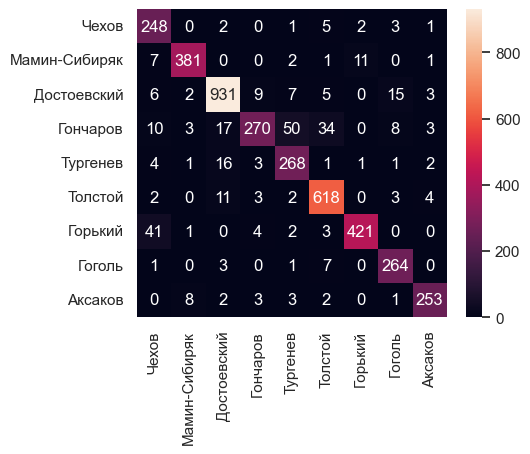

In [10]:
utils.plot_confusion_matrix(
    df_test.author, 
    y_pred, 
    utils.author_rus_surnames(df_test) # чтобы оси были подписаны по-русски
)

#### Ошибочно классифицированные объекты

In [13]:
utils.false_predictions(df_test, df_test.author, y_pred)
# См. первые два столбца (y_true, y_pred)

,y_true,y_pred,author_surname,work_title,excerpt_num,text,lemmas
7,anton-chekhov,maksim-gorkii,Чехов,beglec,1,"Проходя мимо подпрыгивающего парня, он пожал п...",проходить мимо подпрыгивать парень пожать плеч...
11,anton-chekhov,lev-tolstoi,Чехов,beglec,5,В это время вошла сиделка с новыми мисками. На...,это время войти сиделка новый миска миска жарк...
12,anton-chekhov,lev-tolstoi,Чехов,beglec,6,"\n Вернувшись к себе в палату, Пашка сел на кр...",вернуться палата пашка сесть кровать стать дож...
14,anton-chekhov,lev-tolstoi,Чехов,belolobyi,1,и прежде чем пойти дальше: «Полный ход!» При н...,прежде пойти далёкий полный ход немой находить...
15,anton-chekhov,lev-tolstoi,Чехов,belolobyi,2,"Пошел к свистку! \n И свистел, как машина, и п...",пойти свисток свистеть машина го го го го весь...
...,...,...,...,...,...,...,...
3938,sergey-aksakov,ivan-turgenev,Аксаков,semeinaya-khronika,186,"\n Но Афросинья Андревна стоит того, чтоб с не...",афросинья андревич стоить она немного познаком...
3940,sergey-aksakov,nikolai-gogol,Аксаков,semeinaya-khronika,188,"Кальпинского хозяин не жаловал и за то, что он...",кальпинский хозяин жаловать произойти еретик р...
3956,sergey-aksakov,lev-tolstoi,Аксаков,semeinaya-khronika,204,"Степан Михайлыч посмотрел на него, полюбовался...",степан михайлович посмотреть полюбоваться сказ...
3964,sergey-aksakov,dmitriy-mamin-sibiryak,Аксаков,semeinaya-khronika,212,"Через несколько времени дело обошлось, уладило...",несколько время дело обойтись уладиться отноше...


### Кросс-валидация

In [14]:
# Инициализируем пайплайн-классификатор
pipe = utils.AuthorIdentificationTfidfPipeline()

In [ ]:
# y_cv_pred = pd.read_csv('__tmp_y_cv_pred.csv', index_col=0).squeeze("columns")

In [40]:
# Получаем предсказания для кросс-валидации
# (для каждого произведения обучается своя модель:
# во время каждой итерации тестовый датасет - одно 
# из произведений, тренировочный - все остальные произведения).

y_cv_pred, _ = utils.leave_one_title_out_cv_predictions(pipe, df, n_jobs=10)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [30:42<00:00, 13.75s/it]


In [44]:
# По полученным в прошлой ячейке предсказаниям можем посчитать
# среднюю f1-оценку по обученным моделям 
# (взвешенную по числу отрывков для каждого произведения).

_, title_list, score_list, av_sc = utils.leave_one_title_out_cv_score(
    df,
    predictions=y_cv_pred, 
    f1_average='micro'
)

In [45]:
av_sc

0.8943370165745858

In [51]:
# Можно вычислить f1-оценку и напрямую,
# но не знаю, насколько это корректно.
f1_score(df.author, y_cv_pred, average='weighted')

0.8929424578274457

In [ ]:
# Можно сразу использовать функцию leave_one_title_out_cv_score,
# без вызова leave_one_title_out_cv_predictions. 
# Для этого ей в аргументе clf необходимо передать классификатор.
# Пример ниже.

In [52]:
# Бинарная классификация: Толстой или Достоевский.

df_dost_tolst = df[(df.author == 'lev-tolstoi') | (df.author == 'fedor-dostoevskii')]

In [53]:
_, _, score_list, av_sc = utils.leave_one_title_out_cv_score(
    df_dost_tolst,
    clf=pipe, 
    f1_average='micro'
)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:07<00:00,  5.31s/it]


In [54]:
av_sc

0.9910376289193024